# 导入包

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
import os

# 策略网络/演员

## 离散动作

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

## 连续动作

输出正态分布的均值和方差

In [3]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # 也可以直接用tanh激活输出一个固定值, 再缩放为所需动作值
        # 输出均值方差的好处是可以创建一个正态分布, 再采样一次, 还有探索空间
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))  # 最大动作值是2, 因此乘以2缩放
        std = F.softplus(self.fc_std(x))
        return mu, std

# 价值网络 V

In [4]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# PPO 裁剪算法

In [5]:
class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(
        self,
        state_dim: int,
        hidden_dim: int,
        action_dim: int,
        actor_lr: float=1e-4,
        critic_lr: float=5e-3,
        gamma: float=0.9,
        lmbda: float=0.9,
        epochs: int=20,
        eps: float=0.2,
        device: str='cpu',
    ):
        '''
        `state_dim`: 状态空间大小\\
        `hidden_dim`: 隐藏层神经元数量, 若要改隐藏层数量, 需要同步改网络\\
        `action_dim`: 动作空间, 如果是连续动作, 注意调整初始化参数中的action_space\\
        `actor_lr`: 演员梯度上升学习率\\
        `critic_lr`: 评论员梯度上升学习率\\
        `gamma`: 似乎可以去掉，这一项仅用于调整计算优势advantage时，额外调整折算奖励的系数\\
        `lmbda`: # 时序差分学习率，也作为折算奖励的系数之一\\
        `epochs`: PPO内迭代训练多少次\\
        `eps`: 截断范围, 一般0.1或0.2\\
        `device`: 设备, 'cuda'或'cpu'\\
        '''
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma  # 时序差分学习率
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state) -> list:
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), dtype=torch.int).view(-1, 1).to(self.device)
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # 所谓的另一个演员就是原来的演员的初始状态
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        # 因为每次更新是有限度的，不允许一次更新很远，因此需要多次更新才能达到较好效果，这样调整更精细
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            # 重要性, 本来是概率直接相除, 但是取e为底, 自然对数概率相减的幂, 结果是一样的
            ratio = torch.exp(log_probs - old_log_probs)  # 重要性采样系数
            surr1 = ratio * advantage  # 重要性采样
            surr2 = torch.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断的重要性采样
            # PPO损失函数，取上面两者的最小值，加负号，取均值就是损失
            actor_loss = torch.mean(-torch.min(surr1, surr2)) 
            # 评论员更新目标当作标签，加.detach()不纳入计算图
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

# ✅PPO裁剪原理

PPO限制了更新的大小，因此对于同一批数据可以多次训练，这样参数更新会更精确

演员/策略网络损失函数如下（未取均值），应取使其最大化，因此代码中加了负号

![](https://s2.loli.net/2023/07/23/6YZFnoAxfiwX57q.png)

原本是重要性乘以优势函数再乘以演员动作概率的对数，但是与环境交互的演员变成另一个演员了，这个演员在代码中就是原本那个每次训练刚开始时候的初始状态的演员，相当于一个原始副本。

根据A的正负不同，有如下图示，蓝色虚线表示裁剪范围，红色表示最终最小值输出

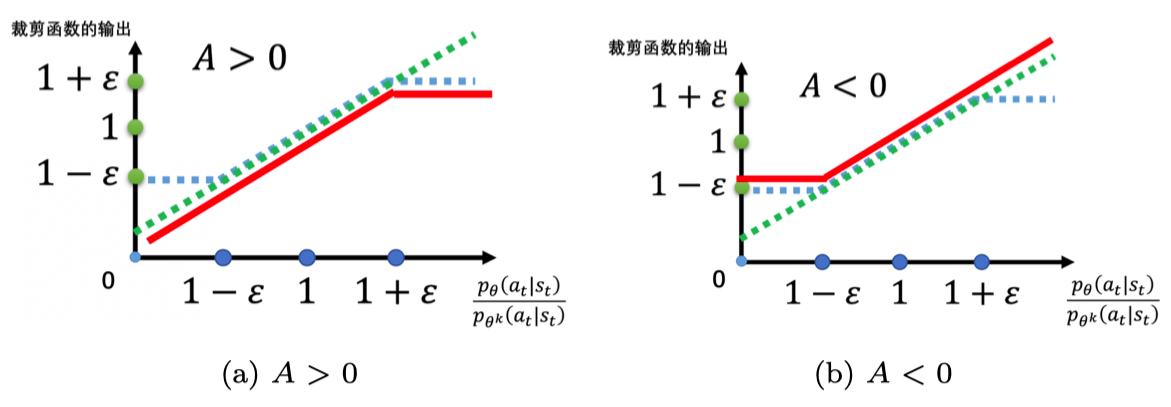

# 离散动作环境

## 初始化参数

In [6]:
# PPO相关
actor_lr = 1e-3
critic_lr = 1e-2
lmbda = 0.95  # 似乎可以去掉，这一项仅用于调整计算优势advantage时，额外调整折算奖励的系数
gamma = 0.98  # 时序差分学习率，也作为折算奖励的系数之一
total_epochs = 15  # 迭代轮数
total_episodes = 100  # 一轮训练多少次游戏

eps = 0.2  # 截断范围参数, 1-eps ~ 1+eps
epochs = 10  # PPO中一条序列训练多少轮，和迭代算法无关
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:', device)

# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
hidden_dim = 128
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, lmbda, epochs, eps, device)

device: cuda


## 检查点函数

In [7]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic.load_state_dict(checkpoint['critic_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

### 读取检查点

In [8]:
CKP_PATH = 'checkpoints/debug/PPO_CPv1.pt'
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)

## 训练

In [9]:
return_list = rl_utils.train_on_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, return_list, CKP_PATH)

总耗时: 0分钟


## 作图

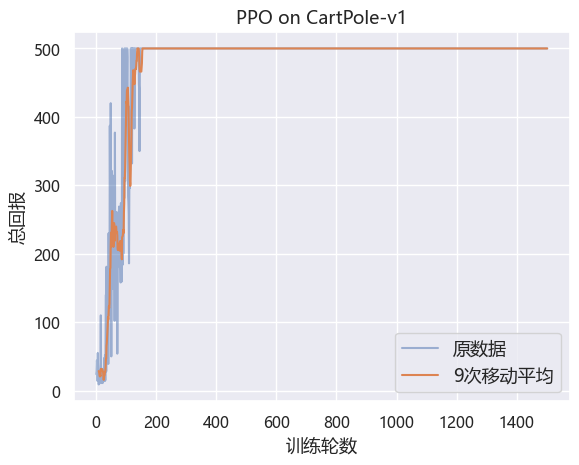

In [10]:
rl_utils.picture_return(return_list, 'PPO', env_name, 9)

平均回报:  499.7


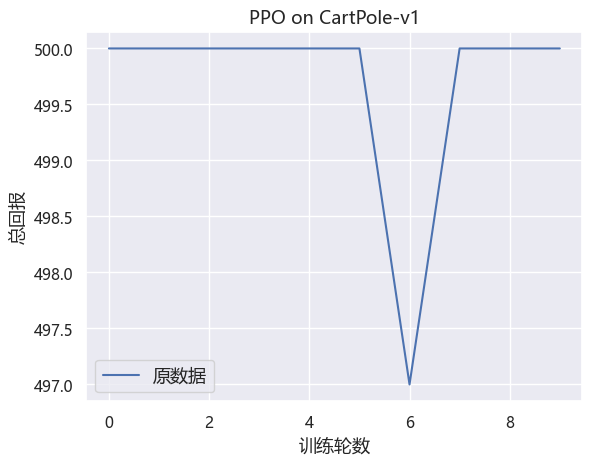

In [11]:
view_list = rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC', if_return=True)

# 连续动作环境

In [12]:
class PPOcontinuous:
    ''' PPO算法,采用截断方式 '''
    def __init__(
        self,
        state_dim: int,
        hidden_dim: int,
        action_dim: int,
        actor_lr: float=1e-4,
        critic_lr: float=5e-3,
        gamma: float=0.9,
        lmbda: float=0.9,
        epochs: int=20,
        eps: float=0.2,
        device: str='cpu',
    ):
        '''
        `state_dim`: 状态空间大小\\
        `hidden_dim`: 隐藏层神经元数量, 若要改隐藏层数量, 需要同步改网络\\
        `action_dim`: 动作空间, 如果是连续动作, 注意调整初始化参数中的action_space\\
        `actor_lr`: 演员梯度上升学习率\\
        `critic_lr`: 评论员梯度上升学习率\\
        `gamma`: 似乎可以去掉，这一项仅用于调整计算优势advantage时，额外调整折算奖励的系数\\
        `lmbda`: # 时序差分学习率，也作为折算奖励的系数之一\\
        `epochs`: PPO内迭代训练多少次\\
        `eps`: 截断范围, 一般0.1或0.2\\
        `device`: 设备, 'cuda'或'cpu'\\
        '''
        
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma  # 时序差分学习率
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state) -> list:
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), dtype=torch.int).view(-1, 1).to(self.device)
        
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样, 对奖励进行修改, 方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dists.log_prob(actions)

        # 因为每次更新是有限度的，不允许一次更新很远，因此需要多次更新才能达到较好效果，这样调整更精细
        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            
            # 重要性, 本来是概率直接相除, 但是取e为底, 自然对数概率相减的幂, 结果是一样的
            ratio = torch.exp(log_probs - old_log_probs)  # 重要性采样系数
            surr1 = ratio * advantage # 重要性采样
            surr2 = torch.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage # 截断的重要性采样
            # PPO损失函数，取上面两者的最小值，加负号，取均值就是损失
            actor_loss = torch.mean(-torch.min(surr1, surr2)) 
            # 评论员更新目标当作标签常数，加.detach()
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

## 初始化参数

In [13]:
# PPO相关
actor_lr = 1e-4
critic_lr = 5e-3
lmbda = 0.9  # 似乎可以去掉，这一项仅用于调整计算优势advantage时，额外调整折算奖励的系数
gamma = 0.9  # 时序差分学习率，也作为折算奖励的系数之一
total_epochs = 20  # 迭代轮数
total_episodes = 200  # 一轮训练多少次游戏

eps = 0.2  # 截断范围参数, 1-eps ~ 1+eps
epochs = 10  # PPO中一条序列训练多少轮，和迭代算法无关
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device:', device)

# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
hidden_dim = 128
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间

agent = PPOcontinuous(state_dim, hidden_dim, action_dim, actor_lr, 
                      critic_lr, gamma, lmbda, epochs, eps, device)

device: cuda


## 读取检查点

In [14]:
CKP_PATH = 'checkpoints/PPO_PDv1.pt'
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)

## 训练

In [18]:
return_list = rl_utils.train_on_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, return_list, CKP_PATH)

总耗时: 0分钟


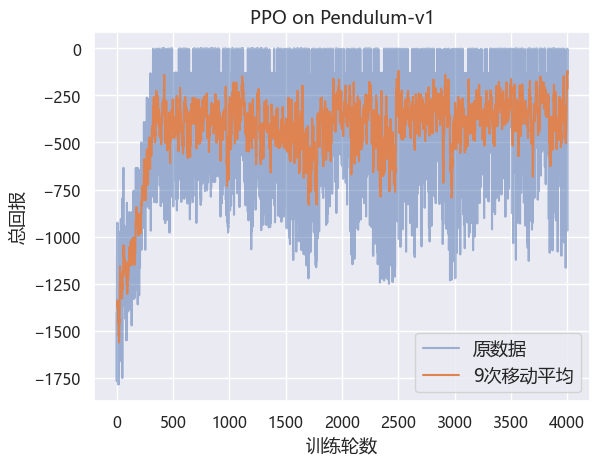

In [19]:
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)
rl_utils.picture_return(return_list, 'PPO', env_name, 9)

平均回报:  -483.994


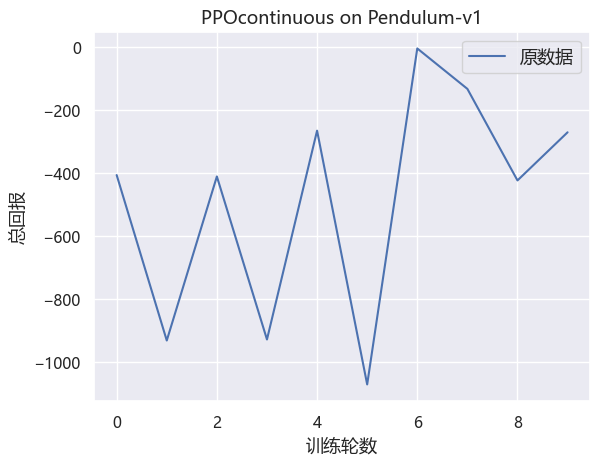

In [15]:
test_list = rl_utils.show_gym_policy(env_name, agent, 'rgb_array', steps=400, model_type='AC', if_return=True)

平均回报:  -426.648


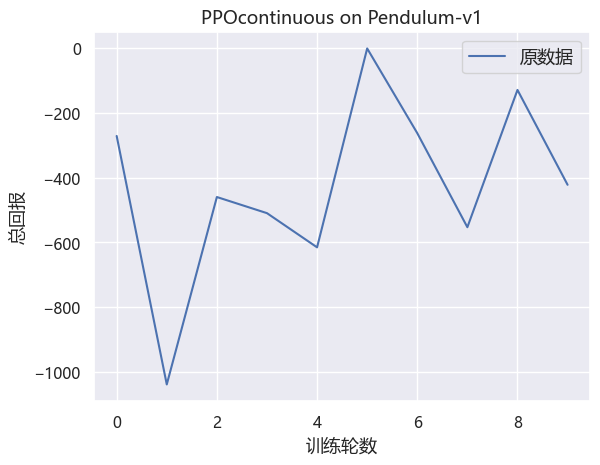

In [16]:
view_list = rl_utils.show_gym_policy(env_name, agent, 'human', epochs=10, model_type='AC', if_return=True)